In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [21]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV

from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('../data/dfLongterm.csv')

In [3]:
data.head()

,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,fea10,...,fea24,fea25,fea26,fea27,fea28,fea29,fea30,fea31,fea32,fea33
0,137.14,-210.30,70.38,-1.80,13.52,7.67,9.21,-4.23,3.85,-2.07,...,0.33,0.34,0.41,0.43,0.20,0.17,0.26,0.54,0.42,0.45
1,96.00,-321.79,105.26,16.30,33.23,11.20,28.95,12.95,16.30,2.92,...,0.55,0.59,0.41,0.38,0.27,0.22,0.09,0.05,0.12,0.25
2,174.55,-216.06,88.31,-8.95,41.89,18.97,7.79,-2.24,5.94,0.00,...,0.25,0.21,0.44,0.21,0.09,0.18,0.31,0.67,0.40,0.53
3,49.23,-185.45,85.01,-8.47,3.75,-17.62,6.10,-14.41,-8.74,-7.15,...,0.24,0.50,0.53,0.20,0.26,0.09,0.14,0.17,0.31,0.33
4,120.00,-209.14,69.00,30.20,31.84,14.17,22.39,5.16,12.23,0.63,...,0.03,0.06,0.12,0.22,0.23,0.18,0.17,0.17,0.43,0.82


In [4]:
y = pd.read_csv('../data/dfY.csv')

In [5]:
y.head()

,index,song_id,valence_mean,arousal_mean
0,0,2,3.1,3.0
1,1,3,3.5,3.3
2,2,4,5.7,5.5
3,3,5,4.4,5.3
4,4,7,5.8,6.4


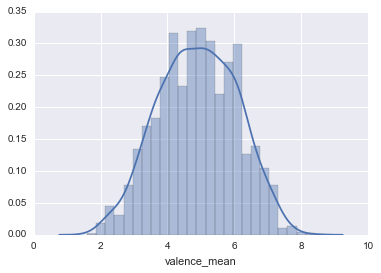

In [6]:
sns.distplot(y['valence_mean'])

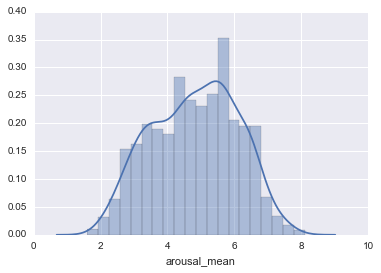

In [7]:
sns.distplot(y['arousal_mean'])

In [8]:
df = pd.concat([data,y['valence_mean'], y['arousal_mean']], axis=1)

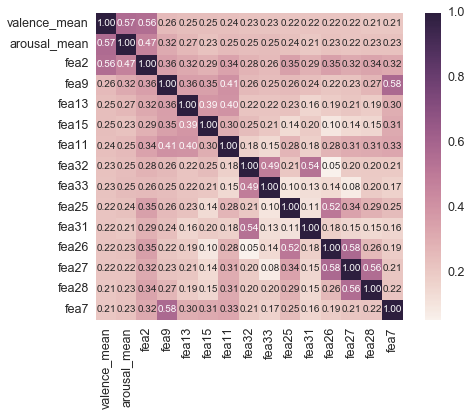

In [11]:
k = 15 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'valence_mean')['valence_mean'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [16]:
scaler = StandardScaler()

In [17]:
scaler.fit(data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
data_scaled = scaler.transform(data)

In [19]:
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

In [20]:
data_scaled.head()

,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,fea10,...,fea24,fea25,fea26,fea27,fea28,fea29,fea30,fea31,fea32,fea33
0,0.655190,-0.076289,-0.775442,-0.034227,-0.765004,0.625078,0.209074,-0.232969,0.167046,0.303801,...,-0.094536,0.119726,0.342517,0.607786,-0.716554,-0.999566,-0.435367,0.917389,0.368432,0.424233
1,-0.697601,-1.237927,0.141235,0.678357,0.547352,0.926323,1.939007,1.843453,1.536770,0.989698,...,1.096746,1.603536,0.342517,0.318272,-0.294819,-0.719813,-1.472541,-1.818019,-1.379786,-0.709320
2,1.885329,-0.136304,-0.304226,-0.315718,1.123963,1.589404,0.084631,0.007548,0.396984,0.588331,...,-0.527729,-0.651855,0.509935,-0.666075,-1.379279,-0.943615,-0.130315,1.643110,0.251884,0.877655
3,-2.235521,0.182628,-0.390953,-0.296821,-1.415522,-1.533136,-0.063474,-1.463352,-1.218080,-0.394467,...,-0.581878,1.069364,1.012190,-0.723977,-0.355067,-1.447171,-1.167490,-1.148123,-0.272581,-0.255899
4,0.091582,-0.064203,-0.811710,1.225590,0.454802,1.179779,1.364115,0.901932,1.088996,0.674927,...,-1.719011,-1.542141,-1.275859,-0.608172,-0.535810,-0.943615,-0.984459,-1.148123,0.426706,2.521308


In [26]:
def modelTest(clf, train, labels):
    cv = KFold(n_splits=5,shuffle=True,random_state=45).split(train)
    mse = make_scorer(mean_squared_error)
    mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
    scores=[mse_val_score.mean()]
    return scores

In [27]:
def modelPlot(result_dict):
    result = pd.DataFrame.from_dict(result_dict, orient='index')
    result.columns = ["Mean Squared Error"] 
    result = result.sort(columns=["Mean Squared Error"],ascending=False)
    #print(result)
    result.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return result

In [28]:
def modelFit(train, labels):
    result_dict = {}
    
    clf = linear_model.LinearRegression()
    result_dict["Linear"] = modelTest(clf, train, labels)
    
    clf = linear_model.Lasso(alpha=1e-4)
    result_dict["Lasso"] = modelTest(clf, train, labels)
    
    clf = linear_model.Ridge()
    result_dict["Ridge"] = modelTest(clf, train, labels)
    
    clf = linear_model.BayesianRidge()
    result_dict["Bayesian Ridge"] = modelTest(clf, train, labels)
    
    clf = linear_model.HuberRegressor()
    result_dict["Huber"] = modelTest(clf, train, labels)
    
    clf = svm.SVR()
    result_dict["SVM RBF"] = modelTest(clf, train, labels)
    
    clf = svm.SVR(kernel="linear")
    result_dict["SVM Linear"] = modelTest(clf, train, labels)
    
    clf = BaggingRegressor()
    result_dict["Bagging"] = modelTest(clf, train, labels)
    
    clf = RandomForestRegressor()
    result_dict["RandomForest"] = modelTest(clf, train, labels)
    
    clf = AdaBoostRegressor()
    result_dict["AdaBoost"] = modelTest(clf, train, labels)
    
    clf = XGBRegressor()
    result_dict["XGBoost"] = modelTest(clf, train, labels)
    
    model_summary = modelPlot(result_dict)
    return model_summary

In [29]:
modelFit(data_scaled, y['valence_mean'])

KeyboardInterrupt: 